# Lab 2.2: Transfer Learning with ResNet50

**Objective:**  
Fine-tune a pre-trained ResNet50 model on a small dataset of plant diseases.  
Compare transfer learning with training from scratch.

Target: ≥ 80% validation accuracy within 10 epochs.

In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [30]:
!pip install tensorflow-datasets

In [31]:
import tensorflow_datasets as tfds
import tensorflow as tf

IMG_SIZE = 224
BATCH_SIZE = 32

# Proper loading
(dataset_dict, info) = tfds.load(
    'tf_flowers',
    with_info=True,
    as_supervised=True
)

dataset = dataset_dict['train']   # Extract actual dataset

def preprocess(img, label):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img, label

dataset = dataset.map(preprocess)
dataset = dataset.shuffle(1000)

# 80/20 split
train_size = int(0.8 * info.splits['train'].num_examples)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

print("Dataset ready.")

Dataset ready.


In [1]:
# 1️⃣ Load pretrained ResNet50 without top classifier
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# 2️⃣ Freeze ALL layers (feature extraction phase)
for layer in base_model.layers:
    layer.trainable = False

# 3️⃣ Build custom classification head
x = base_model.output                    # Feature maps (7x7x2048)
x = GlobalAveragePooling2D()(x)          # Convert to 2048 vector
x = Dense(256, activation='relu')(x)     # Learn task-specific patterns
x = Dropout(0.5)(x)                      # Reduce overfitting
output = Dense(5, activation='softmax')(x)  # 5 plant classes

# 4️⃣ Create final model
model = Model(inputs=base_model.input, outputs=output)

# 5️⃣ Compile for feature extraction
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',  # integer labels
    metrics=['accuracy']
)

print("Phase 1 Model Ready")
model.summary()

NameError: name 'ResNet50' is not defined

In [34]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 306ms/step - accuracy: 0.4229 - loss: 1.5967 - val_accuracy: 0.8651 - val_loss: 0.4524
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - accuracy: 0.7900 - loss: 0.5614 - val_accuracy: 0.8978 - val_loss: 0.3213
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 175ms/step - accuracy: 0.8572 - loss: 0.4087 - val_accuracy: 0.9251 - val_loss: 0.2511
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - accuracy: 0.8806 - loss: 0.3325 - val_accuracy: 0.9292 - val_loss: 0.2300
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step - accuracy: 0.9140 - loss: 0.2631 - val_accuracy: 0.9482 - val_loss: 0.1964
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 176ms/step - accuracy: 0.9078 - loss: 0.2766 - val_accuracy: 0.9510 - val_loss: 0.1700
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 174ms/step - accuracy: 0.9333 - loss: 0.2090 - val_accuracy: 0.9578 - val_loss: 0.1411
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 207ms/step - accuracy: 0.9368 - loss: 0.1909 - val_accu

In [35]:
# 1️⃣ Unfreeze LAST 20 layers only
for layer in base_model.layers[-20:]:
    layer.trainable = True

# 2️⃣ Recompile with LOWER learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # smaller LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Phase 2 Fine-Tuning Started")

Phase 2 Fine-Tuning Started


In [36]:
history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 338ms/step - accuracy: 0.9317 - loss: 0.1866 - val_accuracy: 0.9741 - val_loss: 0.0932
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - accuracy: 0.9603 - loss: 0.1292 - val_accuracy: 0.9782 - val_loss: 0.0721
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - accuracy: 0.9709 - loss: 0.1082 - val_accuracy: 0.9877 - val_loss: 0.0580
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 194ms/step - accuracy: 0.9812 - loss: 0.0848 - val_accuracy: 0.9959 - val_loss: 0.0380
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.9889 - loss: 0.0643 - val_accuracy: 0.9959 - val_loss: 0.0285


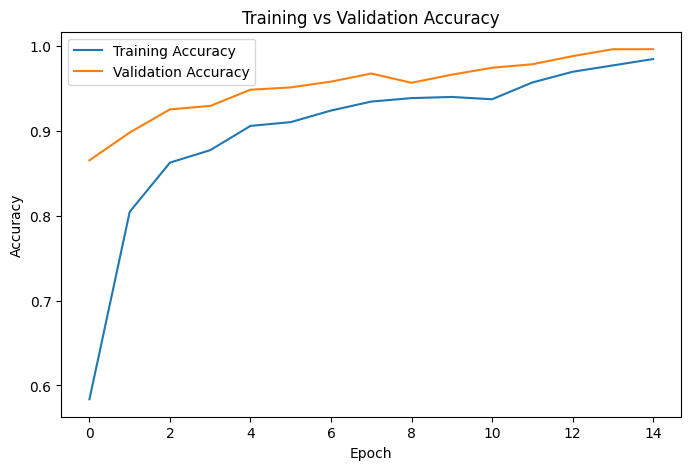

Final Validation Accuracy: 0.9959127902984619


In [37]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.figure(figsize=(8,5))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

print("Final Validation Accuracy:", val_acc[-1])

## Why Transfer Learning Works Better

Transfer learning works effectively because ResNet50 was pre-trained on ImageNet, which contains millions of images. The early convolutional layers learn universal features such as edges, textures, and shapes, which are useful across many visual tasks. By freezing these layers and only training a small classification head, the model adapts quickly to the plant disease dataset. Fine-tuning the deeper layers further improves performance by slightly adjusting high-level features to better match plant disease patterns. Training from scratch would require significantly more data and time, and would likely overfit on this small dataset.